<a href="https://colab.research.google.com/github/so-dipe/Data-Science-and-Machine-Learning-Projects/blob/main/UltraMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! cp /content/drive/MyDrive/kaggle.json  ~/.kaggle/   # If this returns an error, add or remove a space between .json and ~/.kaggle NB: there must always be space between them
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ultra-mnist


100% 17.5G/17.5G [02:20<00:00, 134MB/s]
100% 17.5G/17.5G [02:20<00:00, 134MB/s]


The first thing I did here was to download the dataset from Kaggle, I had the kaggle.json file in my google drive already, so the rest wa pretty straight forward. Then the next thing I did was to unzip the file.

In [ ]:
! unzip ultra-mnist.zip

In [ ]:
! pip install category_encoders

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, Reshape, TimeDistributed, LSTM, Reshape
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import cv2
from category_encoders import OneHotEncoder
#import tensorflow_datasets as tfds

Ok, so a little explaination about the dataset. It contains 28000 training images and 28000 test images. The images have 4000 by 4000 pixels and are black and white. They contain handwritten images like the one in the mnist dataset, but this time, above 3-5 numbers in each image. And the goal is to predict the sum of the numbers in each image.

# Predicting Sum

## Idea 1: Using the Normal Mnist Dataset
I don't know if this is legal in the competition, but the first idea I had was to use the MNIST dataset that comes with tensorflow to classify the numbers in each image. 

### Here is the plan in full details:
1. Train the MNIST dataset using CNNs (model1)
2. Using a rolling window to divide the image in training set and pass these images in the from of a list into (model1.predict()).
3. Find the top 5 most common numbers in each list and sum them up. 

In [ ]:
(X_train, y_train), (X_val, y_val) = mnist.load_data()
print(X_train.shape)
print(X_val.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


As we can see, there are 60000 images in the training set and 10000 in the test set. Now, we train the model using a CNN and check the accuracy.

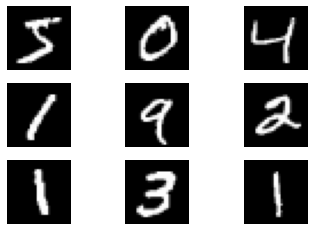

In [ ]:
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
  plt.axis('off')

plt.show()

These are some images in the MNIST dataset.

### Model Baseline

We try to calculate the accuracy score to beat here.

In [ ]:
y_train_series = pd.Series(y_train)
baseline_acc = y_train_series.value_counts().max()/y_train_series.value_counts().sum()
baseline_acc


0.11236666666666667

Therefore, the baseline accuracy of the model is 0.11 or 11%

In [ ]:
y_train_cat = pd.get_dummies(y_train)
y_test_cat = pd.get_dummies(pd.Series(y_val))

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (4, 4), padding='same', input_shape=(28, 28, 1)))
model1.add(Activation('relu'))
model1.add(Conv2D(16, (4, 4), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(8, (4, 4), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(5, 5)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        544       
                                                                 
 activation_48 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 16)        8208      
                                                                 
 activation_49 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 8)         2056      
                                                                 
 activation_50 (Activation)  (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 5, 8)        

In [ ]:
batch_size = 32

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model1.compile(loss='categorical_crossentropy', optimizer=opt, 
               metrics=['accuracy'])
model1.fit(X_train, y_train_cat, batch_size=batch_size, epochs=15, 
           validation_data=(X_val, y_test_cat), shuffle=True)

## Idea 2: Using Convolutional Neural Networks (CNNs) with Long Short Term Memory (LSTM) 

Here, I try to combine CNNs with LSTM. Using some of the ideas in 1, and updatig on them. The first thing I do here is break down the image into smaller pieces using a rolling window and learning the features in theses images using CNNs. These features learned are now part of the sequence network, where a importance (paramaters) is placed on features learned in the past. This I hope will be useful with addition.

In [ ]:
# STEP 1: Load Dataset

image_df = pd.read_csv('train.csv')


In [ ]:
# STEP 2: Create a rolling/sliding window 
def slidingWindow(image, pixels, step): # image should be a numpy array
  image_shape = image.shape
  image_list = list()
  for i in range(1, image_shape[0], step):
    for j in range(1, image_shape[1], step):
      new_image = image[i:i+pixels, j:j+pixels]
      # image_list.append(new_image)
      if new_image.shape[0] == pixels and new_image.shape[1] == pixels:
        image_list.append(new_image)
      else:
        continue
  return image_list

So the plan here is simple, we pass the image in through a pre-trained convolutional neural network (Transfer Learning). This will learn the features in the list of images. The output from the CNN is then passed through a Recurrent Neural Net (RNN) that tries to classify the image list into the 28 categories. The goal here is that the RNN can learn the what images should be part of the sum and what images shouldn't

### STEP 3: Creating the Input Pipeline
The dataset contains 28000 (4000 by 4000 pixels) images, which is pretty large 
and in addition, These images are broken down into smaller pieces of say 200 by 200 pixels, this means that each image in the dataset will be broken down into another dataset containing no less than 1000 images. So loading the entire data into cache at once will be a not so good idea, and the RAM probably won't be able to store all that data. So we have to think of other creative ways to store the training data.

In [ ]:
train_paths = list(glob('/content/train/*.jpeg'))

In [ ]:
image_df = pd.read_csv('train.csv')
image_df.head()

,id,digit_sum
0,vyctxmodyu,12
1,kghlqhpshk,14
2,rfznywdgjo,19
3,zllfkikwrw,24
4,qeiqjoqakl,20


In [ ]:
five_img = dict()
for i in range(5):
  image = Image.open('train/'+image_df['id'][i]+'.jpeg')
  image_array = np.asarray(image)
  five_img['images'] = slidingWindow(image_array, 200, 5)
  five_img['label'] = image_df[i]

## Using OpenCV for text detection.
Here, I try to use openCv for text detection instead of a rolling/sliding window. This is because with the sliding/rolling window, a specific window has to be specified, but the image has numbers of different sizes, this means that to capture all the numbers, we have to use different windows. This increases the number of smaller images we will be getting from each image (especially since the smallest number in each image is about 28 by 28 pixels)

First, we use OpenCV library (cv2) to view a sample image from dataset.

(4000, 4000, 3)

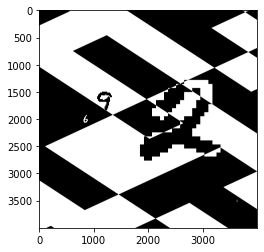

In [ ]:
image = cv2.imread("/content/train/aabsycpixy.jpeg")
plt.imshow(image, cmap=plt.get_cmap('gray'))
image.shape

As, we can see, the numbers in the image are all of different sizes. with the '2' really large (1000+ pixels height and width) and the '6' really small (28 by 28 pixels). Identifying these with the sliding window would just give a lot of residual images and this could lead to an image sequence for each image that is more than the entire dataset.

But using text detection algorithm from OpenCV, we would be able to reduce this number to less than 100 hopefully. 
For text detection using OpenCV, we need to do
1. Convert the image to grayscale (not need here as the image is already in grayscale)
2. Next, we detect edges in the grayscale image using Canny's Algorithm on OpenCv
3. Then we find all contours in the edge image and loop through them creating bounding boxes around them. This should help us detect the text (numbers) in the image.

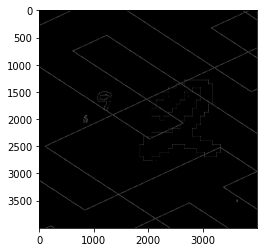

In [ ]:
edge = cv2.Canny(image, 0, 0)
plt.imshow(edge, cmap=plt.get_cmap('gray'))

The above is the result after applying Canny's Algo. Next we find contours and loop through them.

In [ ]:
contours, hierarachy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(contours)

11945

The image as over 10000 contours, this means that over 10000 images will be generated from each image. Which is still a lot, but this number can be reduced since we know that the size of MNIST data is (28 by 28 pixels), so we can remove any image that has less than 28 pixels on either side

In [ ]:
im2 = image.copy() # Create a copy of image to show bounding boxes
croppedimgs = list()
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  # Drawing a rectangle on copied image
  rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
  # Cropping the text block for giving input to OCR
  cropped = image[y:y + h, x:x + w]
  if cropped.shape[0] > 28 and cropped.shape[1] > 28:
    croppedimgs.append(cropped)

len(croppedimgs)

32

By focusing only on images with more than 28 pixel, we've been able to reduce the number of images generated to less than 100. 

Now a little visualization

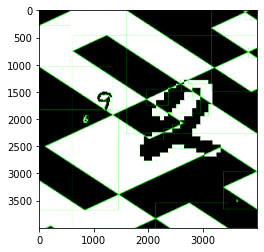

In [ ]:
plt.imshow(im2, cmap=plt.get_cmap('gray'))

This shows all the bounding boxes on the original image, although they are hard to see, we can see the resulting images.

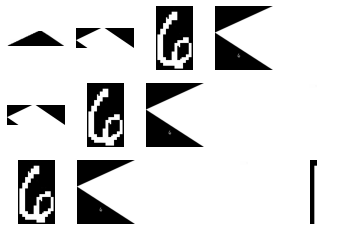

In [ ]:
fig, ax = plt.subplots(3, 5)
for i in range(3):
  for j in range(5):
    ax[i, j].imshow(croppedimgs[i+j], cmap=plt.get_cmap('gray'))
    ax[i, j].axis('off')

In [ ]:
croppedimgs[0].shape

(40, 148, 3)

Although this is not the best plot, we can clearly see that the bounding box method works, as we have been able to isolate the number 6. But another problem we have is the image sizes. They all have different size and this is something we have to fix before feeding them into the neural net.

In [ ]:
def create_imageseq(imgpath):
    croppedimgs = list()
    image = cv2.imread(imgpath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edge = cv2.Canny(blur, 0, 0)
    contours, hierarachy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im2 = image.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Drawing a rectangle on copied image
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Cropping the text block for giving input to OCR
        cropped = image[y:y + h, x:x + w]
        cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        if cropped.shape[0] > 20 and cropped.shape[1] > 20:
            croppedimgs.append(cropped)

    return croppedimgs, im2

The function create_imageseq, does the job we explained above, from Canny's algo to looping through the contours and dropping any image less than 28 pixels.

In [ ]:
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = image[tf.newaxis, ..., tf.newaxis][0]
    image = tf.image.resize_with_pad(image, 100, 100)
    return image

def loadseq(imagepath, df, num=100, encode=True):
    images = list()
    imagespath = glob(imagepath + "/*.jpeg")
    for file in imagespath[:num]:
      image_seq = dict()
      imagearray, im2 = create_imageseq(file)
      cropped_imgarray = [scale_resize_image(image) for image in imagearray]
      image_seq['images'] = cropped_imgarray
      image_seq['class'] = df[df['id'] == file[len(imagepath)+1:-5]]['digit_sum'].values[0]
      # image_seq['class'] = df[df['id'].str.contains(file)]['digit_sum'].values[0]
      images.append(image_seq)
    X, y, y_en = createXY(images)
    max = 0
    for i in range(len(X)):
      if max < len(X[i]):
        max = len(X[i])
    for im in X:
      if len(im) < max:
        fill = max - len(im)
        for i in range(fill):
          im.append(tf.constant(np.zeros((100, 100, 1))))
    X = tf.constant(np.asanyarray(X))
    if encode == True:
      return X, y, y_en
    else:
      return X, y

def createXY(imgarray):
    X = list()
    y = list()
    for imgdict in imgarray:
        X.append(imgdict['images'])
        y.append(imgdict['class'])
    y = pd.DataFrame(y).astype(str)
    ohe = OneHotEncoder(use_cat_names=True).fit(y)
    y_en = ohe.transform(y)
    return X, y, y_en

The first function here resize's the images to a uniform size for the Neural Network. The second function loads the images from file into a list, with each entry in the list being a dictionary, containing the sequence of smaller images for a particular image and the class of that the image belongs to.

In [ ]:
X, y, y_en = loadseq('/content/train', image_df, 10)

In [ ]:
image_df.head()

,id,digit_sum
0,vyctxmodyu,12
1,kghlqhpshk,14
2,rfznywdgjo,19
3,zllfkikwrw,24
4,qeiqjoqakl,20


This function divides the image array gotten from loadseq into X and Y

In [ ]:
image_shape = (50, 50, 1)
kernel_size = (3, 3)
pool_size = (2, 2)
filters = 32
convNet = Sequential([
    Conv2D(filters, kernel_size, padding='valid', input_shape=image_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(11),
    Activation('softmax')
])

classification_layers = [
    TimeDistributed(convNet, input_shape=(49, 50, 50, 1)),
    LSTM(4, activation='relu', input_shape=(11,)),
    Dense(28, activation='softmax')
]



model = Sequential(classification_layers)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 49, 11)           2177899   
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 4)                 256       
                                                                 
 dense_2 (Dense)             (None, 28)                140       
                                                                 
Total params: 2,178,295
Trainable params: 2,178,295
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
convNet.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classification_layers[0].trainable = False

In [ ]:
convNet.fit(X_train_rescale, y_train_cat)

1875/1875 [==============================] - 380s 202ms/step - loss: 0.2193 - accuracy: 0.9359


In [ ]:
X_train_rescale = list()
for i in range(len(X_train)):
  X_train_rescale.append(scale_resize_image(X_train[i]))  

In [ ]:
X_train_rescale = np.asanyarray(X_train_rescale)

In [ ]:
convNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                        

In [ ]:
classification_layers = [
    TimeDistributed(convNet, input_shape=(58, 50, 50, 1)),
    Reshape((11, 58)),
    LSTM(4, activation='relu', input_shape=(11,)),
    Dense(128, activation='relu'),
    Dense(28, activation='softmax')
]
model = Sequential(classification_layers)
model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 58, 11)           2177899   
 tributed)                                                       
                                                                 
 reshape_2 (Reshape)         (None, 11, 58)            0         
                                                                 
 lstm_4 (LSTM)               (None, 4)                 1008      
                                                                 
 dense_8 (Dense)             (None, 128)               640       
                                                                 
 dense_9 (Dense)             (None, 28)                3612      
                                                                 
Total params: 2,183,159
Trainable params: 5,260
Non-trainable params: 2,177,899
________________________________________

In [ ]:
model.fit(X_new, y_en, epochs=10)

Epoch 1/10
32/32 [==============================] - 79s 2s/step - loss: 3.3329 - accuracy: 0.0410
Epoch 2/10
32/32 [==============================] - 77s 2s/step - loss: 3.3300 - accuracy: 0.0420
Epoch 3/10
32/32 [==============================] - 76s 2s/step - loss: 3.3274 - accuracy: 0.0370
Epoch 4/10
32/32 [==============================] - 76s 2s/step - loss: 3.3262 - accuracy: 0.0480
Epoch 5/10
32/32 [==============================] - 76s 2s/step - loss: 3.3240 - accuracy: 0.0410
Epoch 6/10
32/32 [==============================] - 77s 2s/step - loss: 3.3233 - accuracy: 0.0420
Epoch 7/10
32/32 [==============================] - 76s 2s/step - loss: 3.3235 - accuracy: 0.0360
Epoch 8/10
32/32 [==============================] - 76s 2s/step - loss: 3.3222 - accuracy: 0.0350
Epoch 9/10
32/32 [==============================] - 76s 2s/step - loss: 3.3224 - accuracy: 0.0380
Epoch 10/10
32/32 [==============================] - 94s 3s/step - loss: 3.3213 - accuracy: 0.0510


In [ ]:
X_new = list()
for i in range(len(X)):
  X_new.append(tf.constant(np.asanyarray(X[i])))

type(X_new)

list

In [ ]:
y_en.sum()

In [ ]:
y_train_cat['none'] = 0
y_train_cat.head()

,0,1,2,3,4,5,6,7,8,9,none
0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
tf.transpose(X_new[0][0]).shape

TensorShape([1, 50])

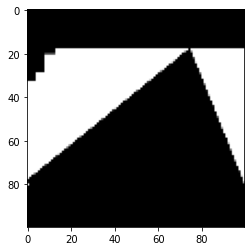

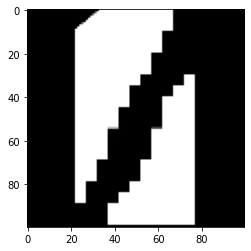

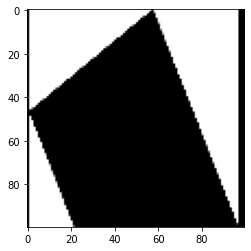

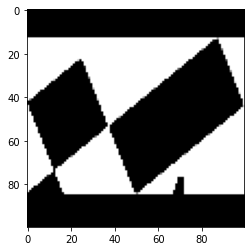

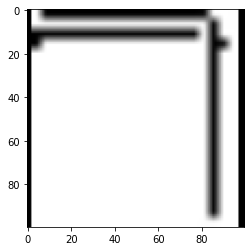

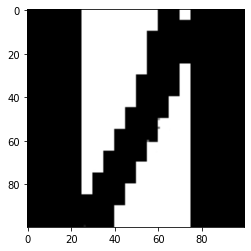

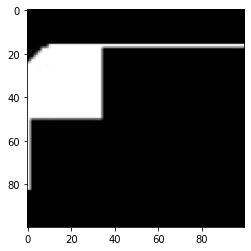

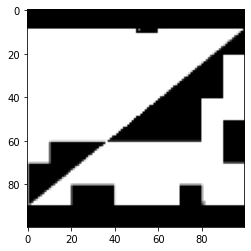

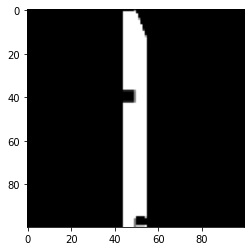

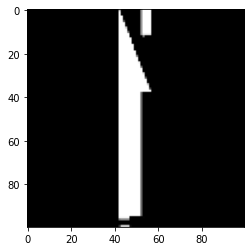

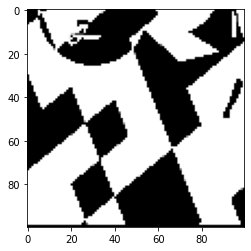

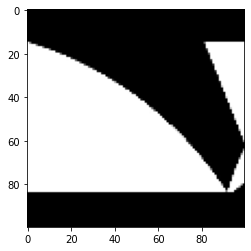

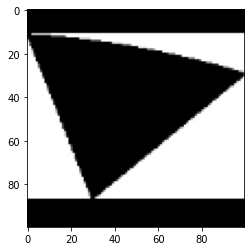

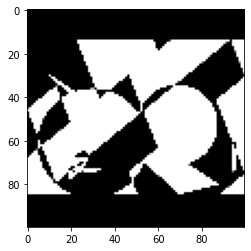

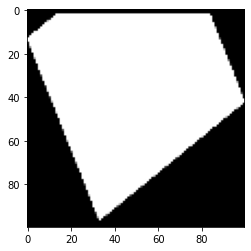

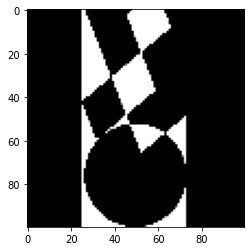

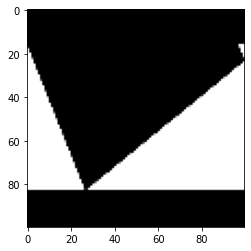

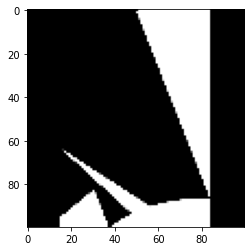

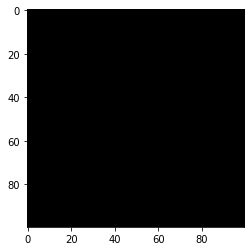

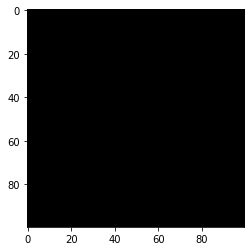

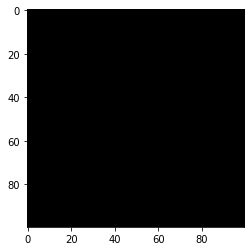

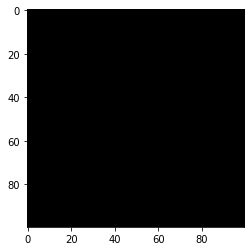

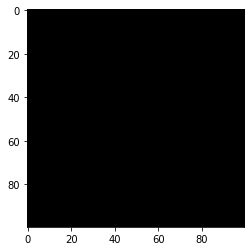

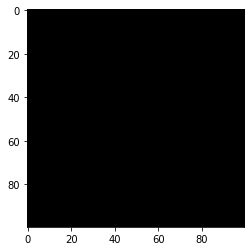

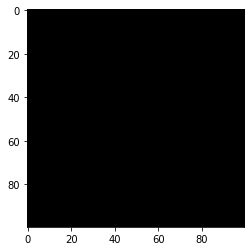

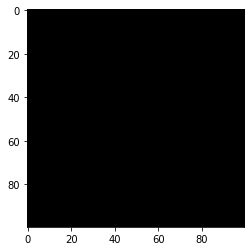

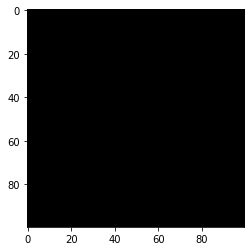

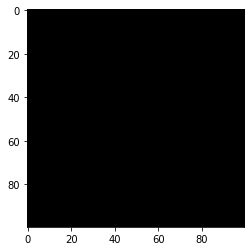

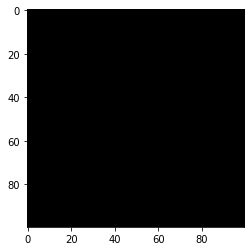

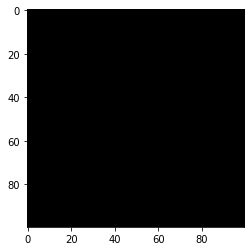

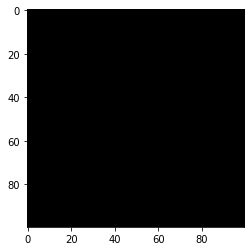

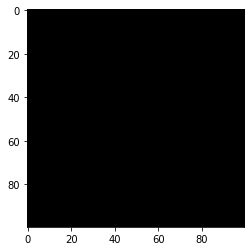

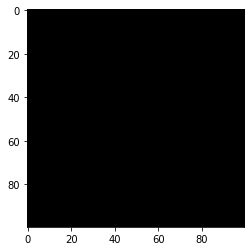

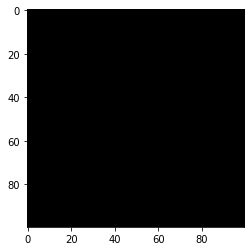

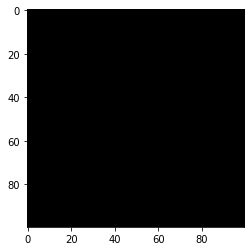

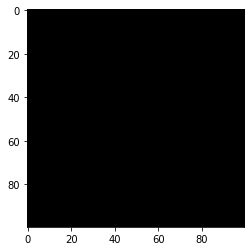

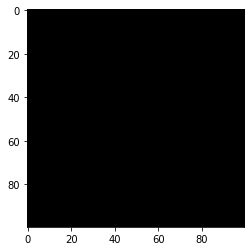

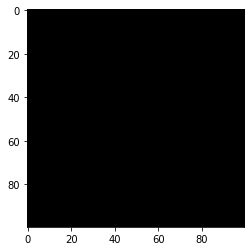

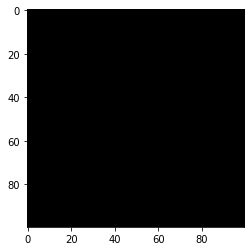

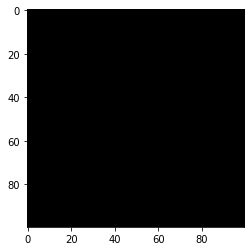

InvalidArgumentError: ignored

In [ ]:
for i in range(58):
  plt.imshow(np.asanyarray(X[1][i]).squeeze(axis=2), cmap=plt.get_cmap('gray'))
  plt.show()